In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import scienceplots

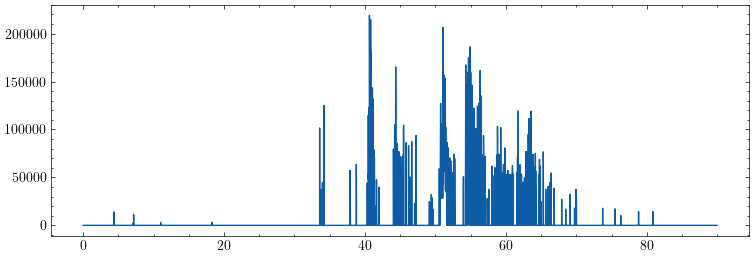

In [3]:
data = pd.read_csv('../sample_data/4502.csv')

plt.style.use('science')
# Visualize the rough EIC
plt.figure(figsize=(9, 3))
plt.plot(data['RT'], data['Intensity'])

Epoch 1/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0970 - val_loss: 3.0732e-05
Epoch 2/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0052 - val_loss: 1.0797e-05
Epoch 3/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0053 - val_loss: 7.8841e-06
Epoch 4/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0051 - val_loss: 7.1615e-06
Epoch 5/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0054 - val_loss: 6.8998e-06
Epoch 6/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0053 - val_loss: 6.7803e-06
Epoch 7/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0053 - val_loss: 6.7170e-06
Epoch 8/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0052 - val_loss: 6.6804e-06
Epoch 9/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0052 - val_loss: 6.6574e-06
Epoch 10/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0053 - val_loss: 6.6422e-06
Epoch 11/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0049 - val_loss: 6.6318e-

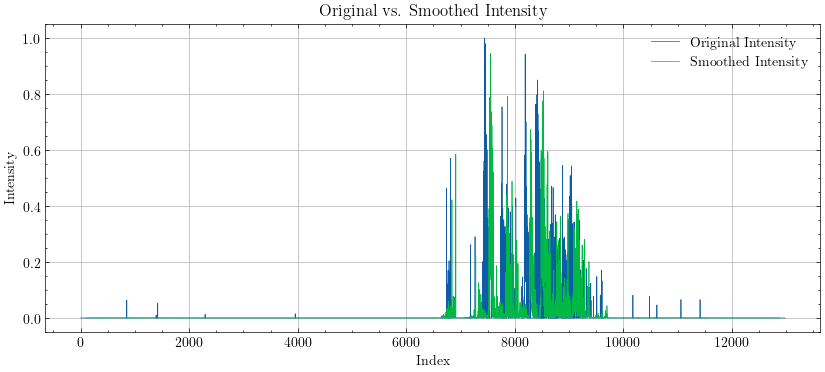

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('../sample_data/4502.csv')

# Normalize the intensity values
scaler = MinMaxScaler()
data['Intensity'] = scaler.fit_transform(data['Intensity'].values.reshape(-1, 1))

# Function to create sliding windows
def create_sliding_window(data, window_size=5):
    """
    Creates sliding windows from intensity values.
    Each window contains `window_size` consecutive intensity values.
    """
    X = []
    for i in range(len(data) - window_size + 1):
        X.append(data['Intensity'].iloc[i:i + window_size].values)
    return np.array(X)

# Define window size
window_size = 200
X = create_sliding_window(data, window_size)

# Define the autoencoder structure
input_dim = X.shape[1]  # Number of features per input (size of sliding window)

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoder: Compress data into a lower-dimensional representation
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)

# Decoder: Reconstruct data from the compressed representation
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Combine encoder and decoder to create autoencoder
autoencoder = Model(input_layer, decoded)

# Compile the model with mean squared error (MSE) loss and Adam optimizer
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X, X, epochs=100, batch_size=32, shuffle=True, validation_split=0.2)

# Predict denoised data
denoised_data = autoencoder.predict(X)

# Reconstruct smoothed intensities from denoised sliding windows
# Take the first value from each sliding window for reconstruction
smoothed_intensities = [denoised_data[i][0] for i in range(len(denoised_data))]

# Adjust lengths by padding NaNs for non-overlapping regions
# Calculate the total difference in length
total_diff = len(data) - len(smoothed_intensities)

# Padding to match the original data length
if total_diff > 0:
    smoothed_intensities = np.concatenate((
        np.full((window_size - 1) // 2, np.nan),  # Padding at the start
        smoothed_intensities,                     # Smoothed values
        np.full(total_diff - (window_size - 1) // 2, np.nan)  # Padding at the end
    ))
else:
    # Truncate the smoothed intensities if somehow they are longer
    smoothed_intensities = smoothed_intensities[:len(data)]

# Add smoothed intensities to the original dataframe
data['smoothed_intensity'] = smoothed_intensities

data['smoothed_intensity'] = data['smoothed_intensity'].clip(lower=0)  # Clip negative values to 0


# Visualize the results
plt.figure(figsize=(10, 4))
plt.plot(data['Intensity'], label='Original Intensity', linewidth = 0.5)
plt.plot(data['smoothed_intensity'], label='Smoothed Intensity', linewidth = 0.5)
plt.xlabel('Index')
plt.ylabel('Intensity')
plt.title('Original vs. Smoothed Intensity')
plt.legend()
plt.grid(True)
plt.show()


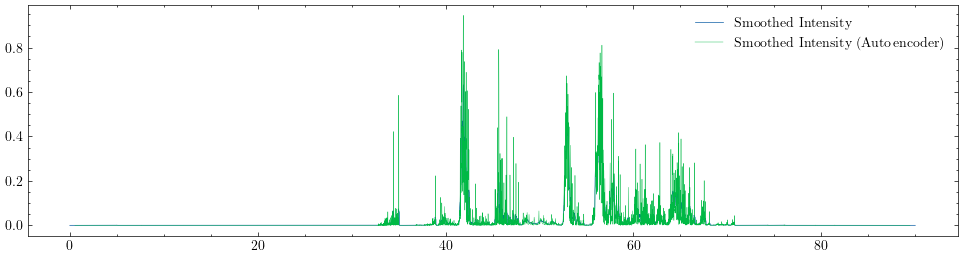

In [60]:
def moving_average(data, window_size=5):
    """
    Apply a moving average filter to the data.
    """
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

# Apply moving average to the smoothed intensities
data['smoothed_intensity_ma'] = moving_average(data['smoothed_intensity'].fillna(0), window_size=10)

# Visualize the results
plt.figure(figsize=(12, 3))
plt.plot(data['RT'], data['smoothed_intensity_ma'], label='Smoothed Intensity', linewidth = 0.5)
plt.plot(data['RT'], data['smoothed_intensity'], label='Smoothed Intensity (Autoencoder)', linewidth = 0.3)
plt.legend()

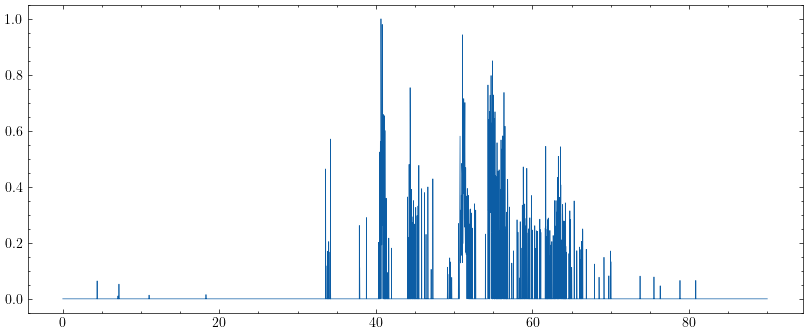

In [45]:
plt.figure(figsize=(10, 4))
plt.plot(data['RT'], data['Intensity'], label='Original Intensity', linewidth = 0.5)